In [1]:
%matplotlib inline

# ToDo :
## Target : ```See the accuracy change within 40 epochs on Dilated convolution```
##  Results :    ```Parameters: 98,960    Accuracy : 74%```
## Analysis : ```4 Convolution layers and 3 MPs indicate that we want to see Edges&Gradients, Textures&Patterns, Parts Of Objects and Objects.```


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Code to check GPU availability

In [4]:
SEED = 1
# Check if CUDA is available
cuda = torch.cuda.is_available()
print("Is CUDA available : ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# Data loader argumens for train and test
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# Test loader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

Is CUDA available :  True


Let us show some of the training images, for fun.



plane   dog  deer  deer


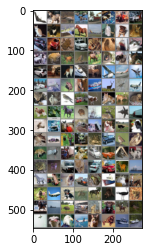

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(16))# Input=32x32x3 Output=32x32x8 RF=3x3
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=2, dilation=2, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(32))# Input=16x16x8 Output=16x16x16 RF=8x8
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(64))# Input=8x8x16 Output=8x8x32 RF=18x18
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(128))# Input=4x4x32 Output=4x4x64 RF=38x38
        self.pool = nn.MaxPool2d(2, 2)
        
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1,1), padding=0, bias=False))

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.conv4(x)
        x = self.gap(x)
        x = self.conv5(x)
        x = x.view(-1, 10)
        return x


net = Net()

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Defaulting to user installation because normal site-packages is not writeable
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,608
              ReLU-6           [-1, 32, 16, 16]               0
       BatchNorm2d-7           [-1, 32, 16, 16]              64
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,432
             ReLU-10             [-1, 64, 8, 8]               0
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Conv2d-13

Method to Train Model

In [8]:
from tqdm import tqdm

train_losses = []
train_acc = []
def train(model, device, trainloader, optimizer, epoch, reg_type):
    running_loss = 0.0
    correct = 0
    processed = 0
    pbar = tqdm(trainloader)
    for i, data in enumerate(pbar):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update pbar tqdm 
        output = outputs.argmax(dim=1, keepdim=True)
        correct += (output == labels).sum().item()
        processed += len(inputs)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={100. * correct / processed:0.2f}')

print('Finished Training')

Finished Training


Method to Test the Model

In [9]:
test_losses = []
test_acc = []
def test(model, device, test_loader, reg_type):
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            test_loss += F.nll_loss(outputs, labels, reduction='sum').item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss)
    print('\nTest Set: Average loss: {}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(testloader.dataset),
                                                                        100. * correct / len(testloader.dataset)))
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 1
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print("EPOCH: ", epoch)
    train(net, device, trainloader, optimizer, epoch, 'l1')
    test(net, device, testloader, 'l1')
    

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  0


Loss=1.6136934757232666 Batch_id=390 Accuracy=1289.26: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]



Test Set: Average loss: -15674.90678024292, Accuracy: 4581/10000 (45.81%)

Accuracy of the network on the 10000 test images: 45 %


5. We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  deer  ship horse


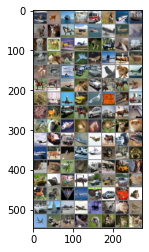

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   dog plane horse


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 45 %
Accuracy of  bird : 13 %
Accuracy of   cat : 21 %
Accuracy of  deer : 30 %
Accuracy of   dog : 42 %
Accuracy of  frog : 65 %
Accuracy of horse : 55 %
Accuracy of  ship : 66 %
Accuracy of truck : 51 %
